In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as intpol
from scipy.optimize import curve_fit
import numpy as np
from blackbody import *
from mag_flux_convert import *

wavelength = {'UVW2':2030., 'UVM2':2231., 'UVW1':2634., 'U':3571., 'B':4344., 'V':5456., 'R':6442., 'I':7994., 
       'J':12200., 'H':16458., 'KS':21603.}
col = {'UVW2':'purple', 'UVM2':'purple', 'UVW1':'purple', 'U':'blue', 'B':'blue', 'V':'green', 'R':'green', 'I':'green', 
       'J':'red', 'H':'red', 'KS':'red'}

In [2]:
def get_mag_interpol(mag_intpol, day):
    """return x = numpy.array of wavelength, y = numpy.array of intpolated magnitude, z = numpy.array of band
    mag_intpol = dict of scipy.interpolate.interp1d with keys as bands
    day = one number representing day for interpolation
    wavelength = dict of wavelength with keys as bands, pre-defined"""
    x = []
    y = []
    z = []
    for i in mag_intpol.keys():
        if np.isnan(mag_intpol[i](day).tolist()):
            continue
        x.append(wavelength[i])
        y.append(mag_intpol[i](day).tolist())
        z.append(i)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    return x, y, z

In [3]:
# load
sn = pd.read_csv(r"D:\Unknown 3rd project\2009ip\Default\python\01_01_sn2009ip_clean.dat")

In [4]:
# explore
sn.columns
sn['band'].unique()

array(['UVW1', 'U', 'UVW2', 'UVM2', 'B', 'I', 'R', 'V', 'H', 'J', 'KS'],
      dtype=object)

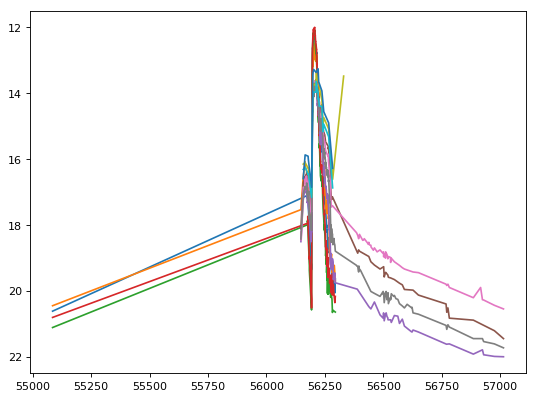

In [5]:
# plot
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
for i in sn['band'].unique():
    x = sn[['MJD', 'Vegamag']].where(sn['band'] == i).dropna()
    plt.plot(x['MJD'], x['Vegamag'])
plt.gca().invert_yaxis()
plt.show()

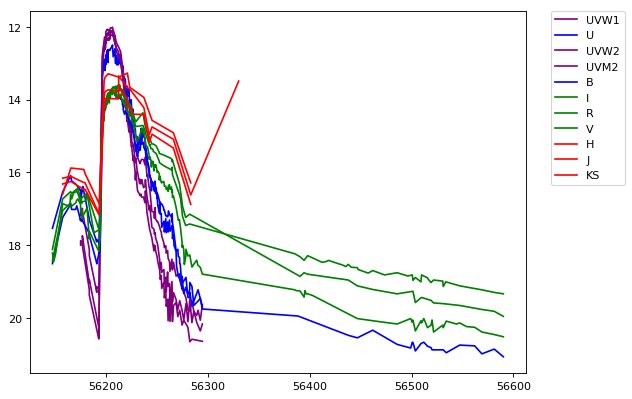

In [6]:
# plot
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
for i in sn['band'].unique():
    x = sn[['MJD', 'Vegamag']].where(sn['band'] == i).dropna().query('MJD>56000 & MJD<56600')
    plt.plot(x['MJD'], x['Vegamag'], color=col[i], label=i)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [7]:
# subset 56000--56600
dat = sn.query('MJD>=56000 & MJD<=56600')
dat.head()

,MJD,Vegamag,emag,band
4,56147.23,18.51,0.01,B
5,56147.23,18.12,0.05,I
6,56147.23,18.22,0.03,R
7,56147.23,17.54,0.01,U
8,56147.23,18.43,0.04,V


In [8]:
# interpolate for each band
mag_intpol = {}
for i in dat['band'].unique():
    mag_intpol[i] = intpol.interp1d(
        dat['MJD'].where(dat['band'] == i).dropna(), 
        dat['Vegamag'].where(dat['band'] == i).dropna(), 
        fill_value=None, bounds_error=False)

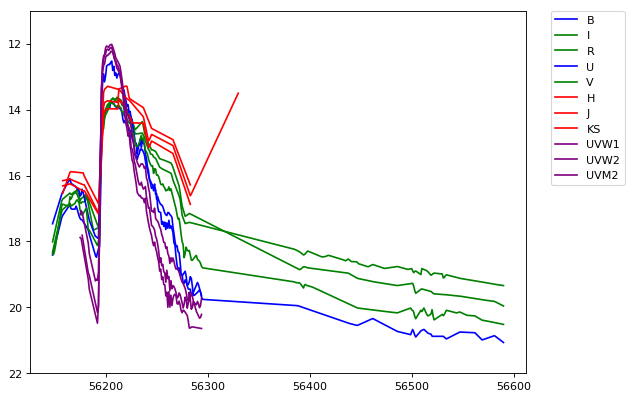

In [9]:
# plot interpolate
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
z = np.arange(56000, 56600, step=1)
col = {'UVW2':'purple', 'UVM2':'purple', 'UVW1':'purple', 'U':'blue', 'B':'blue', 'V':'green', 'R':'green', 'I':'green', 
       'J':'red', 'H':'red', 'KS':'red'}
for i in mag_intpol.keys():
    plt.plot(z, mag_intpol[i](z), color=col[i], label=i)
plt.ylim(11, 22)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:
# fit blackbody
# UV--KS
z = np.arange(56000, 56600, step=1)
MJD = []
param = []
paramcov = []
for j in z:
    x, y, a = get_mag_interpol(mag_intpol, j)
    if y.size < 3:
        continue
    popt, pcov = curve_fit(bb_lambda_mag, x, y, p0=[5000., -20.])
    MJD.append(j)
    param.append(popt)
    paramcov.append(pcov)
MJD = np.array(MJD)
param = np.array(param)
paramcov = np.array(paramcov)

In [11]:
# fit BB : UVW2--UVW1 + B--I
z = np.arange(56000, 56600, step=1)
band_UV = set(['UVW2', 'UVM2', 'UVW1'])
band_opt = set(['B', 'V', 'R', 'I'])
MJD2_UV = []
MJD2_opt = []
param2_UV = []
param2_opt = []
paramcov2_UV = []
paramcov2_opt = []
for j in z:
    x, y, a = get_mag_interpol(mag_intpol, j)
    x_UV = []
    y_UV = []
    x_opt = []
    y_opt = []
    for i in a:
        if i in band_UV:
            x_UV.append(wavelength[i])
            y_UV.append(y[np.where(a == i)].tolist()[0])
        if i in band_opt:
            x_opt.append(wavelength[i])
            y_opt.append(y[np.where(a == i)].tolist()[0])
    
    x_UV = np.array(x_UV)
    y_UV = np.array(y_UV)
    x_opt = np.array(x_opt)
    y_opt = np.array(y_opt)
    if x_UV.size >= 2:
        popt, pcov = curve_fit(bb_lambda_mag, x_UV, y_UV, p0=[5000., -20.])
        MJD2_UV.append(j)
        param2_UV.append(popt)
        paramcov2_UV.append(pcov)
    if x_opt.size >=2:
        popt, pcov = curve_fit(bb_lambda_mag, x_opt, y_opt, p0=[5000., -20.])
        MJD2_opt.append(j)
        param2_opt.append(popt)
        paramcov2_opt.append(pcov)        
                
MJD2_UV = np.array(MJD2_UV)
param2_UV = np.array(param2_UV)
paramcov2_UV = np.array(paramcov2_UV)
MJD2_opt = np.array(MJD2_opt)
param2_opt = np.array(param2_opt)
paramcov2_opt = np.array(paramcov2_opt)

C:\Users\Kornpob\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


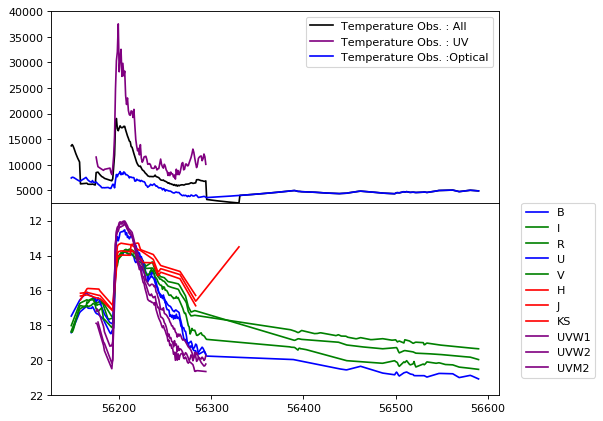

In [12]:
# plot temperature evolution with photometry
fig = plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.1, 0.5, 0.7, 0.4],
                   xticklabels=[], ylim=(2500,40000))
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4],
                   ylim=(22, 11))

ax1.plot(MJD, param[:,0], 'k', label='Temperature Obs. : All')
ax1.plot(MJD2_UV, param2_UV[:,0], color='purple', label='Temperature Obs. : UV')
ax1.plot(MJD2_opt, param2_opt[:,0], 'b', label='Temperature Obs. :Optical')
ax1.legend()

col = {'UVW2':'purple', 'UVM2':'purple', 'UVW1':'purple', 'U':'blue', 'B':'blue', 'V':'green', 'R':'green', 'I':'green', 
       'J':'red', 'H':'red', 'KS':'red'}
for i in mag_intpol.keys():
    ax2.plot(MJD, mag_intpol[i](MJD), color=col[i], label=i)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

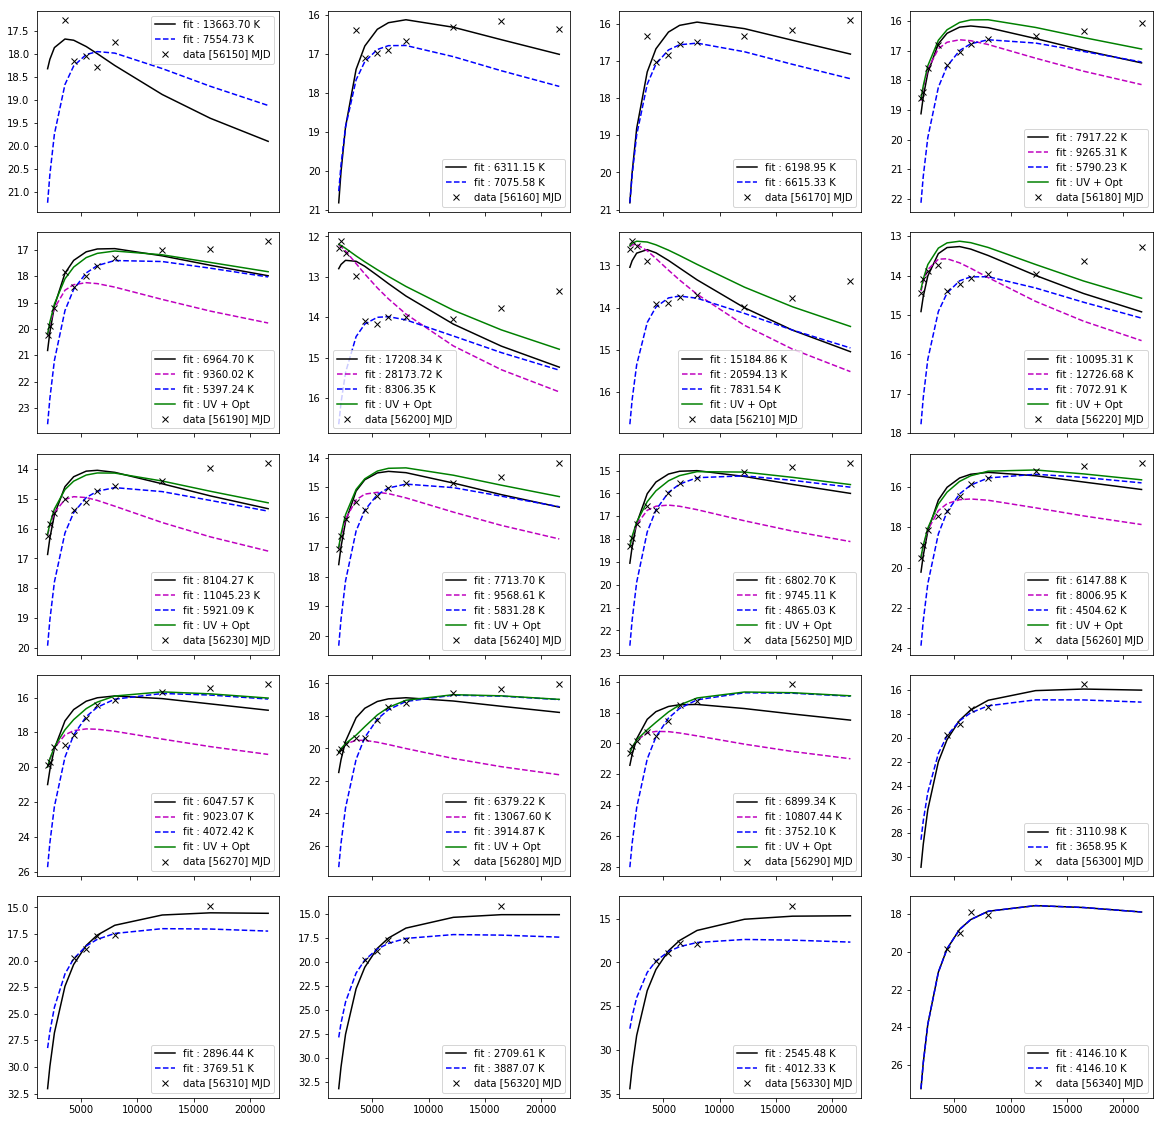

In [13]:
# plot SEDs
z = np.arange(56150, 56350, step=10)
ncol = 4
nrow = int(z.size / ncol)
fig, AX = plt.subplots(nrow, ncol, sharex=True, figsize=(20,5*ncol))
fig.subplots_adjust(hspace=0.1)

j = 0
for ax in AX.flatten():
    index = np.array(np.where(MJD == z[j]))
    if index.size == 0:
        j += 1 
        continue
    x = np.fromiter(wavelength.values(), dtype=float)
    y = get_bb_mag(x, param[index,0], param[index,1])
    o = x.argsort()
    ax.plot(x[o], y[o], 'k-', label='fit : ' + '{:.2f}'.format(param[index,0][0,0]) + ' K')  
    
    if (z[j] in MJD2_UV):
        index = np.array(np.where(MJD2_UV == z[j]))
        x = np.fromiter(wavelength.values(), dtype=float)
        yuv = get_bb_mag(x, param2_UV[index,0], param2_UV[index,1])
        o = x.argsort()
        ax.plot(x[o], yuv[o], 'm--', label='fit : ' + '{:.2f}'.format(param2_UV[index,0][0,0]) + ' K')
    
    if (z[j] in MJD2_opt):
        index = np.array(np.where(MJD2_opt == z[j]))
        x = np.fromiter(wavelength.values(), dtype=float)
        yopt = get_bb_mag(x, param2_opt[index,0], param2_opt[index,1])
        o = x.argsort()
        ax.plot(x[o], yopt[o], 'b--', label='fit : ' + '{:.2f}'.format(param2_opt[index,0][0,0]) + ' K')
        
    if (z[j] in MJD2_UV & z[j] in MJD2_UV):
        ytot = flux2mag(mag2flux(yopt, x) + mag2flux(yuv, x), x)
        o = x.argsort()
        ax.plot(x[o], ytot[o], 'g-', label='fit : UV + Opt')
#         indexopt = np.array(np.where(MJD2_opt == z[j]))
#         indexuv = np.array(np.where(MJD2_UV == z[j]))
#         x = np.fromiter(wavelength.values(), dtype=float)
#         yopt = get_bb_mag(x, param2_opt[index,0], param2_opt[index,1])
#         yuv = get_bb_mag(x, param2_opt[index,0], param2_opt[index,1])
        
        
        
#         o = xopt.argsort()
#         index = np.array(np.where(MJD2_UV == z[j]))
#         xuv = np.fromiter(wavelength.values(), dtype=float)
#         yuv = get_bb_mag(xuv, param2_UV[index,0], param2_UV[index,1])
#         o = xuv.argsort()
#         ax.plot(xopt[o], yopt[o]+yuv[o], color='gray', linestyle='-', label='fit : ' + '{:.2f}'.format(param2_opt[index,0][0,0]) + ' K')
    
    index = np.array(np.where(MJD == z[j]))
    x, y, a = get_mag_interpol(mag_intpol, z[j])
    o = x.argsort()
    ax.plot(x[o], y[o], 'kx', label='data ' + '{}'.format(MJD[index][0]) + ' MJD')
    
    ax.invert_yaxis()
    ax.legend()
    
    j += 1
    
plt.show()

# Conclusion

- $UVW2$--$UVW1$ fits good with BB. This extends to $U$ in most epochs.
- $BVRI$ fits good with BB.
- $BVRI$ from UV+optical fit over fits.
- $JHK$ excess is seen in most epochs from the optical fit.
- Temperature floor is obvious at about 4000 K, with the light curve declines slower than $^{56}$Co rate. During these epochs, $R$ excess is obvious, may be, due to the H$\alpha$ emission.

# Next

- Try two-BB fit simultaneously.
- Try subtracting optical fit from UV. Then, fit UV with something: power law?
- Try color index.
- Try other objects.